# **Model Klasifikasi Gambar Bersih Kotor**

## **Import Required Library**

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
pandas-gbq 0.28.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet, EfficientNetB0, EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2025-06-07 08:27:38.499289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749284858.691827      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749284858.751800      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Data Preparation**

#### pengambilan dataset clean-dirty-containers-in-montevideo

In [ ]:
# # Direktori awal untuk train, test, dan val
# train_dir = "/kaggle/input/clean-dirty-containers-in-montevideo/clean-dirty-garbage-containers-V6.1/clean-dirty-garbage-containers/train"
# test_dir = "/kaggle/input/clean-dirty-containers-in-montevideo/clean-dirty-garbage-containers-V6.1/clean-dirty-garbage-containers/test"

# # Direktori baru untuk dataset gabungan
# combined_dir = "/kaggle/working/dataset"

# # Buat direktori baru untuk dataset gabungan
# os.makedirs(combined_dir, exist_ok=True)

# # Salin file dan folder dari train
# for category in os.listdir(train_dir):
#     category_dir = os.path.join(train_dir, category)
#     if os.path.isdir(category_dir):
#         shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# for category in os.listdir(test_dir):
#     category_dir = os.path.join(test_dir, category)
#     if os.path.isdir(category_dir):
#         shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

#### pengambilan dataset Bersih-Kotor

In [ ]:
# Direktori awal untuk train, test, dan val
dir_ = "/kaggle/input/bersih-kotor-dataset/bersih_kotor_v5"

# Direktori baru untuk dataset gabungan
combined_dir = "/kaggle/working/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(dir_):
    category_dir = os.path.join(dir_, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

In [ ]:
# Define source path
clean_dirty_path = "/kaggle/working/dataset"

# Melihat Jumlah data per kelas dan total data
counter = 0

for i in range(len(os.listdir(clean_dirty_path))):
  label = os.listdir(clean_dirty_path)[i]
  counter += len(os.listdir(f'{clean_dirty_path}/{label}'))
  print(f"{label} = {len(os.listdir(f'{clean_dirty_path}/{label}'))}")

print('-' * 15)
print(f"Total data pada dataset: {counter}")

dirty = 2700
clean = 2700
---------------
Total data pada dataset: 5400


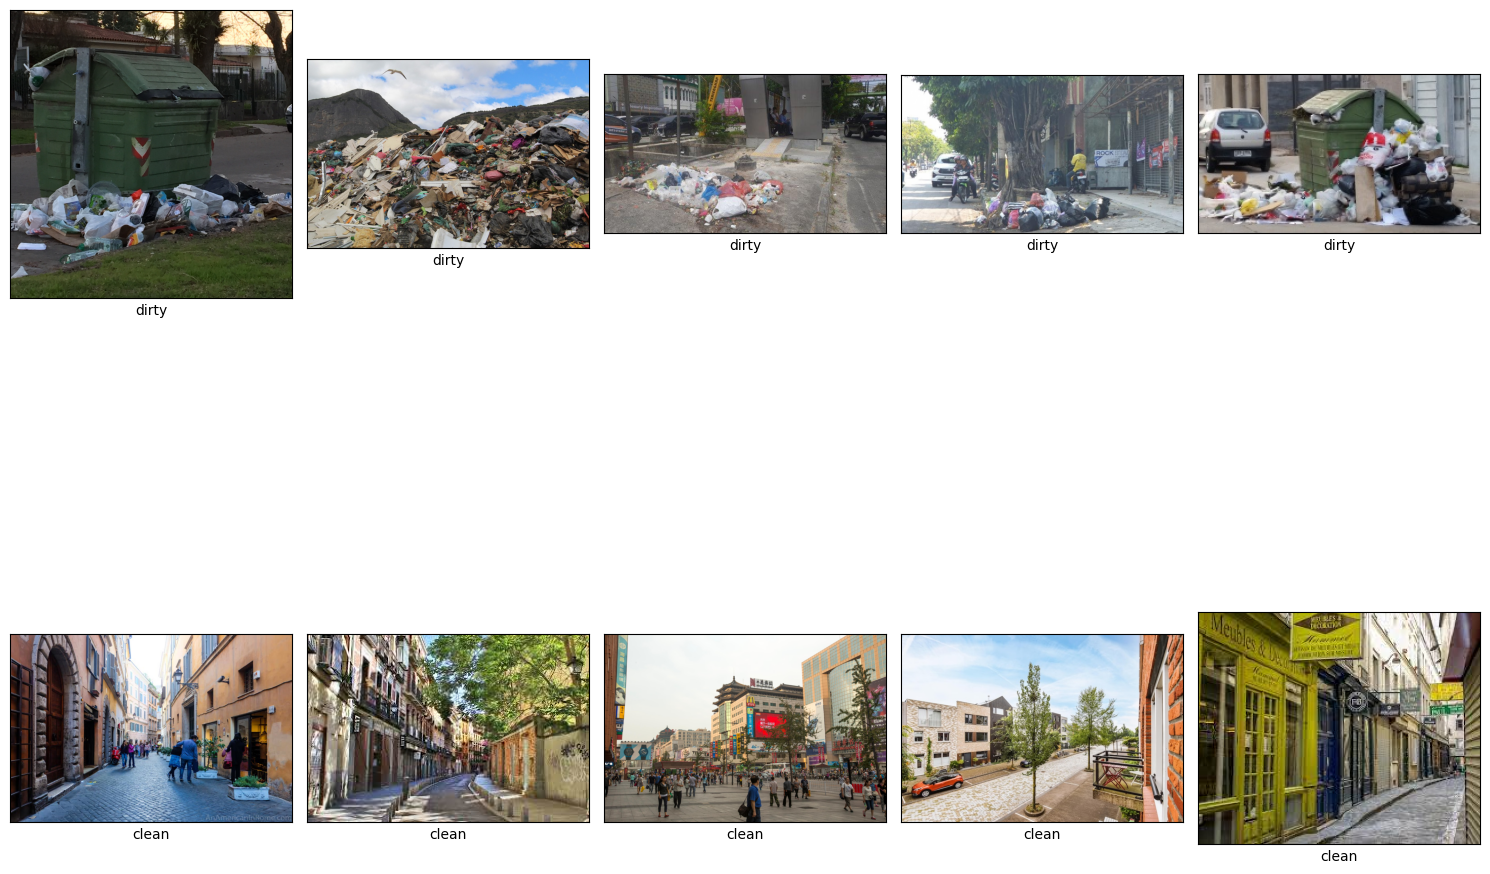

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
clean_dirty_image = {}

# Path sumber train
path = "/kaggle/working/"
path_sub = os.path.join(path, "dataset")

for class_name in os.listdir(path_sub):
    clean_dirty_image[class_name] = os.listdir(os.path.join(path_sub, class_name))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(clean_dirty_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(clean_dirty_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()
plt.show()

## **Data Preprocessing**

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
# Path data akan dikumpulkan dalam dataframe untuk memudahkan reproduksi dalam split data
# Maksudnya, ketika notebook ini di run ulang, data untuk train dan val bisa tetap sama
mypath= "/kaggle/working/dataset"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
clean    2700
dirty    2700
dtype: int64

### Split Dataset

In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X = df['path']
y = df['labels']

# Split dataset menjadi train,test, val
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Komposisi 80, 10, 10
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})
df_val = pd.DataFrame({'path':X_val,'labels':y_val,'set':'val'})

In [ ]:
print('train size', len(df_tr))
print('test size', len(df_te))
print('val size', len(df_val))

train size 4320
test size 540
val size 540


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te, df_val], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')


set    labels
test   clean      259
       dirty      281
train  clean     2177
       dirty     2143
val    clean      264
       dirty      276
dtype: int64 




In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "/kaggle/working/dataset"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "/kaggle/working/Dataset-Final/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

## **Modeling**

In [ ]:
TRAIN_DIR = "/kaggle/working/Dataset-Final/train/"
TEST_DIR = "/kaggle/working/Dataset-Final/test/"
VAL_DIR = "/kaggle/working/Dataset-Final/val/"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 4320 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 540 images belonging to 2 classes.


In [ ]:
base_model = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze layer awal

# Custom classifier di atas base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x) # Regularisasi tambahan
x = Dropout(0.3)(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=preds)

I0000 00:00:1749284910.767940      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749284910.768619      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,214,180 (16.08 MB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 4,049,827 (15.45 MB)

In [ ]:
# model.compile(optimizer=Adam(learning_rate=0.0005),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
def check_accuracy(epoch, logs):
    acc = logs.get('accuracy')
    val_acc = logs.get('val_accuracy')
    if acc > 0.95 and val_acc > 0.95:
        print(f"\nAccuracy dan Val Accuracy sudah lebih besar dari 95% di epoch {epoch+1}, training dihentikan!")
        model.stop_training = True

accuracy_threshold = LambdaCallback(on_epoch_end=check_accuracy)

In [ ]:
checkpoint = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, verbose=1)

In [ ]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[accuracy_threshold, earlystop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1749284932.696887      92 service.cc:148] XLA service 0x7cb170005250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749284932.697761      92 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749284932.697784      92 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749284934.639761      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/135 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.3984 - loss: 0.9580    

I0000 00:00:1749284944.124124      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.8266 - loss: 0.3867
Epoch 1: val_accuracy improved from -inf to 0.92963, saving model to best_model.h5
135/135 ━━━━━━━━━━━━━━━━━━━━ 145s 869ms/step - accuracy: 0.8270 - loss: 0.3859 - val_accuracy: 0.9296 - val_loss: 0.1982
Epoch 2/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9353 - loss: 0.1851
Epoch 2: val_accuracy did not improve from 0.92963
135/135 ━━━━━━━━━━━━━━━━━━━━ 103s 766ms/step - accuracy: 0.9353 - loss: 0.1850 - val_accuracy: 0.9278 - val_loss: 0.1565
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9458 - loss: 0.1598
Epoch 3: val_accuracy improved from 0.92963 to 0.94444, saving model to best_model.h5
135/135 ━━━━━━━━━━━━━━━━━━━━ 104s 772ms/step - accuracy: 0.9458 - loss: 0.1598 - val_accuracy: 0.9444 - val_loss: 0.1453
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.9460 - loss: 0.1372
Epoch 4: val_accuracy did not improve from 0.94444
135/135 ━━━━━━━━━━━━━━━━━

## **Evaluation & Visualization**

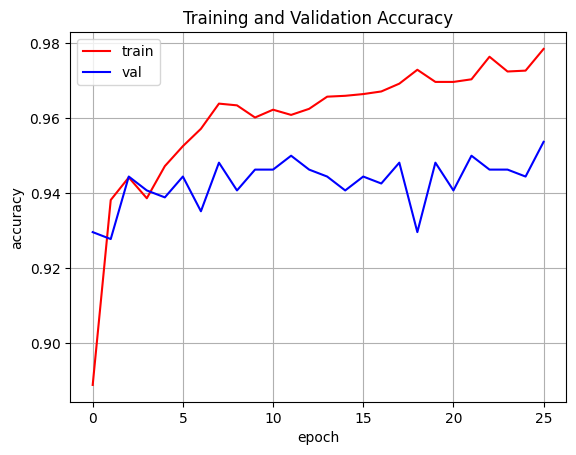

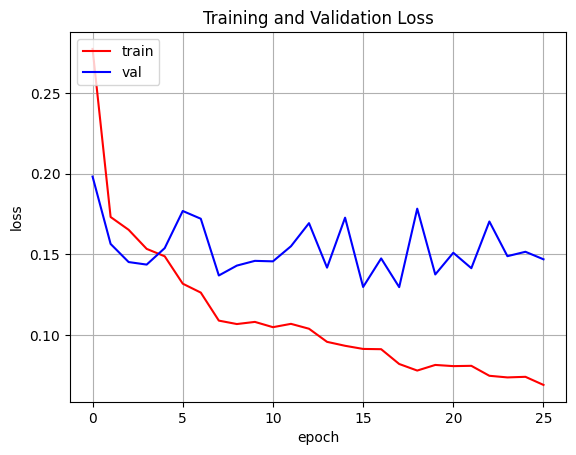

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
# Fine-tune: buka sebagian layer akhir
base_model.trainable = True

# Hanya fine-tune dari layer ke-100 ke atas (misal)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Re-compile dengan learning rate lebih kecil untuk fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history_finetune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[accuracy_threshold, earlystop]
)

Epoch 1/10


E0000 00:00:1749287679.149893      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749287679.292804      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749287679.767513      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749287679.908667      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


135/135 ━━━━━━━━━━━━━━━━━━━━ 174s 851ms/step - accuracy: 0.8382 - loss: 0.4246 - val_accuracy: 0.9278 - val_loss: 0.1912
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 103s 764ms/step - accuracy: 0.9023 - loss: 0.2676 - val_accuracy: 0.9167 - val_loss: 0.2160
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 104s 774ms/step - accuracy: 0.9133 - loss: 0.2261 - val_accuracy: 0.9111 - val_loss: 0.2101
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 103s 764ms/step - accuracy: 0.9205 - loss: 0.2085 - val_accuracy: 0.9204 - val_loss: 0.2269
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 104s 773ms/step - accuracy: 0.9236 - loss: 0.1988 - val_accuracy: 0.9315 - val_loss: 0.2241
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 104s 769ms/step - accuracy: 0.9350 - loss: 0.1794 - val_accuracy: 0.9278 - val_loss: 0.2103
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 105s 778ms/step - accuracy: 0.9482 - loss: 0.1579 - val_accuracy: 0.9296 - val_loss: 0.1598
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 104s 772ms/step - accuracy: 0.9454 - loss: 0.15

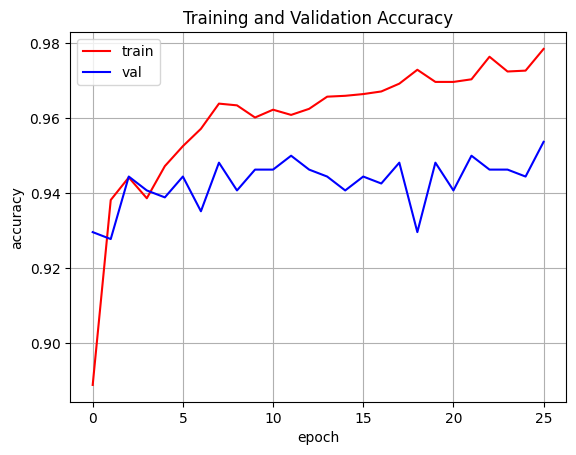

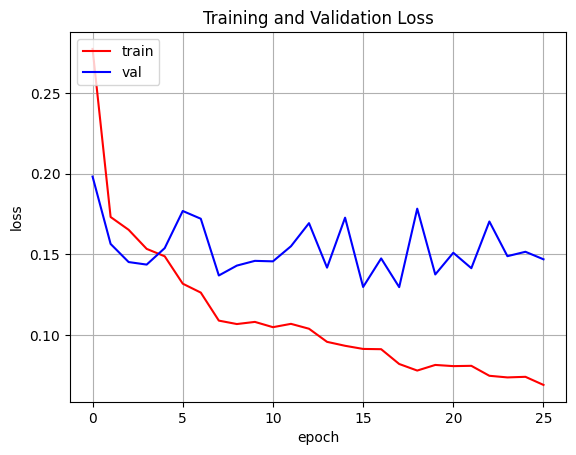

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

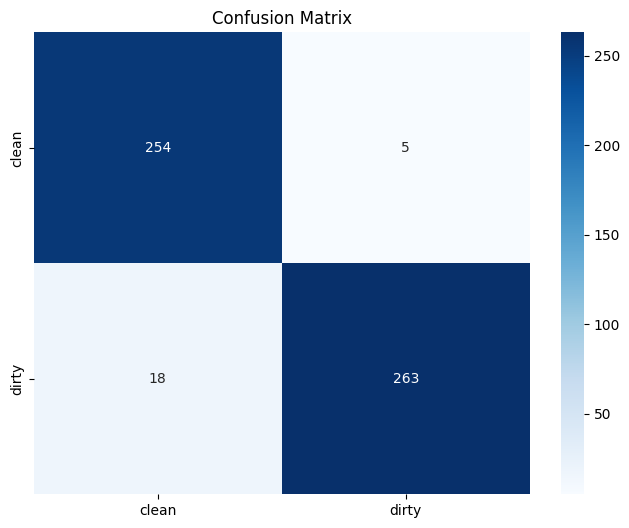


Classification Report:

              precision    recall  f1-score   support

       clean     0.9338    0.9807    0.9567       259
       dirty     0.9813    0.9359    0.9581       281

    accuracy                         0.9574       540
   macro avg     0.9576    0.9583    0.9574       540
weighted avg     0.9586    0.9574    0.9574       540



In [ ]:
test_generator.reset()

preds = model.predict(test_generator, verbose=0)
preds_labels = (preds > 0.5).astype(int).flatten()

# Confusion Matrix
cm = pd.DataFrame(
    data=confusion_matrix(test_generator.classes, preds_labels),
    index=test_generator.class_indices.keys(),
    columns=test_generator.class_indices.keys()
)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(
    y_true=test_generator.classes,
    y_pred=preds_labels,
    target_names=list(test_generator.class_indices.keys()),
    digits=4
))

## **Konversi Model**

In [ ]:
saved_path = '/kaggle/working/saved_model'
tf.saved_model.save(model, saved_path)

In [ ]:
# Path folder yang ingin di-zip
saved_path = '/kaggle/working/saved_model'

# Path output file zip
output_zip = '/kaggle/working/saved_model.zip'

# Membuat zip file
shutil.make_archive(base_name=output_zip.replace('.zip', ''), format='zip', root_dir=saved_path)

'/kaggle/working/saved_model.zip'

In [ ]:
print(test_generator.class_indices)

{'clean': 0, 'dirty': 1}


In [ ]:
# Simpan mapping class ke file
class_map = {0: "Bersih", 1: "Kotor"}
with open("class.txt", "w") as f:
    for k, v in class_map.items():
        f.write(f"{k}:{v}\n")

In [ ]:
import os
import shutil

# Buat folder output
os.makedirs("model_exports", exist_ok=True)

# 1. Save ke .h5
model.save("model_exports/model.h5")

# 2. Save ke SavedModel
model.export("model_exports/saved_model")

# 3. Save sebagai JSON + Weights
with open("model_exports/model.json", "w") as json_file:
    json_file.write(model.to_json())
model.save_weights("model_exports/model.weights.h5")

# 4. Save format .keras
model.save("model_exports/model.keras")

# 5. Zip seluruh folder
shutil.make_archive("model_bundle", 'zip', "model_exports")


Saved artifact at 'model_exports/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137104507292560: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137104507291216: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137105494727888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137105494729040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137105494728656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137105494726928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137105494727696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137105494729616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137105494732112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137105494730960: TensorSpec(shape=(), dtype=tf.resource, 

'/kaggle/working/model_bundle.zip'

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model model_exports/saved_model/ model_exports/tfjs_model_from_saved/


2025-06-07 09:33:43.310088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749288823.331176     939 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749288823.337637     939 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
I0000 00:00:1749288832.973982     939 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12792 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749288832.974706     939 gpu_device.cc:2022] Created device /job:localhost/replica:0

In [ ]:
import shutil

# Buat zip dari seluruh folder model_exports
shutil.make_archive("model_bundle", 'zip', "model_exports")


'/kaggle/working/model_bundle.zip'

In [ ]:
from IPython.display import FileLink

# Tampilkan link download langsung
FileLink("model_bundle.zip")


/kaggle/working/model_bundle.zip

In [ ]:
import zipfile

# Bungkus file class.txt menjadi class.zip
with zipfile.ZipFile("class.zip", 'w') as zipf:
    zipf.write("class.txt")

# Tampilkan link download
from IPython.display import FileLink
FileLink("class.zip")


/kaggle/working/class.zip

In [ ]:
print(test_generator.class_indices)

{'clean': 0, 'dirty': 1}
